# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import *
from sklearn.model_selection import train_test_split
import pickle

C:\Users\onoza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


## データを読む1

In [2]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
#train_data = np.load("../1_data/imagedatagenerator/train_data_expansion.npy")
#train_label = np.load("../1_data/imagedatagenerator/train_label_expansion.npy")

print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

#データ拡張
#train_data_expansion = np.load("../1_data/imagedatagenerator/train_data_expansion.npy")
#train_label_expansion = np.load("../1_data/imagedatagenerator/train_label_expansion.npy")
#print("train_data_expansion.shape=", train_data_expansion.shape)
#print("train_label_expansion.shape=", train_label_expansion.shape)
#
#train_data = np.concatenate([train_data, train_data_expansion])
#train_label = np.concatenate([train_label, train_label_expansion])
#
#print("train_data.shape=", train_data.shape)
#print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [3]:
from PIL import Image

def show_image(img): 
    pil_img = Image.fromarray(img)
    plt.imshow(pil_img)
    plt.gray()
    plt.show()
    return

#for i in range(3000):
#    
#    if(0.99<np.random.rand()):        
#        img = train_data[i]
#        img = img.reshape(28,28)
#        img = np.uint8(img*255)
#        show_image(img)
#
#        img = train_data[3000+i]
#        img = img.reshape(28,28)
#        img = np.uint8(img*255)
#        show_image(img)
#

In [4]:
# 正規化
print(train_data.max())
print(train_data.min())

train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

255.0
0.0


In [5]:
# 配列形式変更
#train_data = train_data.reshape(-1, 28*28)
#print("train_data.shape=", train_data.shape)

## trainとtestに分割する

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2, random_state=1234, shuffle=True)

print(X_train.shape, X_test.shape)

(2400, 1, 28, 28) (600, 1, 28, 28)


## 学習

In [7]:
#%%debug
epochs = 5
batch_size = 256
lr = 0.01
convLayerNum = 4
affineLayerNum = 3
bnLayerNum = 2

# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

#optimizer = RMSProp(lr=0.001, rho=0.9)
optimizer = Adam(lr=0.001, rho1=0.9, rho2=0.999)
#optimizer = SGD(lr=0.01)




# CNNのオブジェクト生成
snet = SimpleConvNet(batch_size, input_dim=(1, 28, 28), 
                     conv_param={'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=256, output_size=15, weight_init_std=0.01, weight_decay_lambda=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        #print("it=%s"%it)

        """
        ランダムなミニバッチを順番に取り出す
        """
        #print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = X_train[mask]
        t_train = y_train[mask]

        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録

    # 訓練データにおけるloss
#     print("calculating train_loss")    
    #train_loss.append(snet.loss(X_train,  y_train))

#     print("calculating test_loss")
    # テストデータにおけるloss
    test_loss.append(snet.loss(X_test, y_test))

#     print("calculating train_accuracy")
    # 訓練データにて精度を確認
    train_accuracy.append(snet.accuracy(X_train, y_train))
    
#     print("calculating test_accuracy")
    # テストデータにて精度を算出
    test_accuracy.append(snet.accuracy(X_test, y_test))
    
    print(train_accuracy[-1], test_accuracy[-1])
    
    #テストデータで98.5%の精度が出たら学習終了
    if(test_accuracy[-1] > 0.985):
        break
        

epoch=0
0.5570833333333334 0.5333333333333333
epoch=1
0.8404166666666667 0.8033333333333333
epoch=2
0.9158333333333334 0.9016666666666666
epoch=3
0.9408333333333333 0.91
epoch=4
0.9583333333333334 0.93


   test_loss  train_accuracy  test_accuracy
0   7.426948        0.557083       0.533333
1   5.304025        0.840417       0.803333
2   4.562907        0.915833       0.901667
3   4.166387        0.940833       0.910000
4   3.757228        0.958333       0.930000


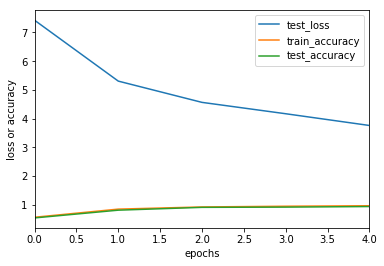

In [8]:
# lossのグラフ化
#df_log = pd.DataFrame({"train_loss":train_loss,
#             "test_loss":test_loss,
#             "train_accuracy":train_accuracy,
#             "test_accuracy":test_accuracy})
df_log = pd.DataFrame({"test_loss":test_loss,
                       "train_accuracy":train_accuracy,
                       "test_accuracy":test_accuracy})
print(df_log)
df_log.plot()
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

predict_label ku
correct_label u


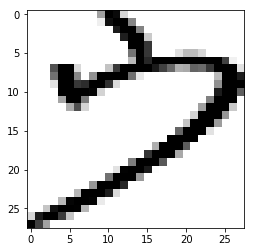

predict_label i
correct_label ke


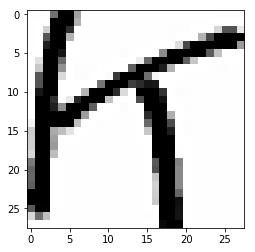

predict_label si
correct_label se


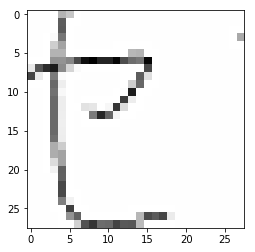

predict_label se
correct_label i


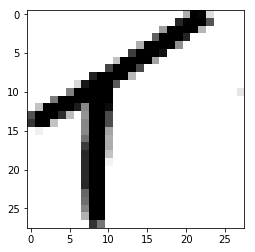

predict_label se
correct_label ka


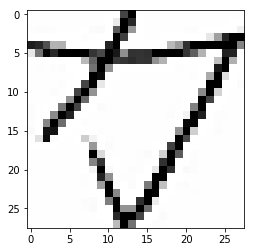

predict_label sa
correct_label ka


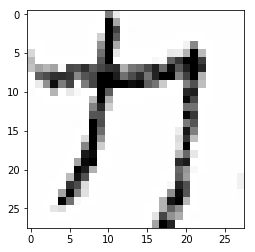

predict_label ke
correct_label ku


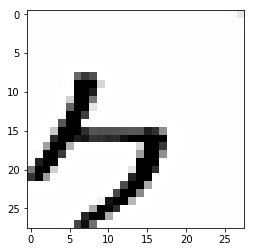

predict_label so
correct_label ku


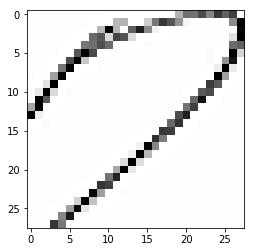

predict_label ko
correct_label u


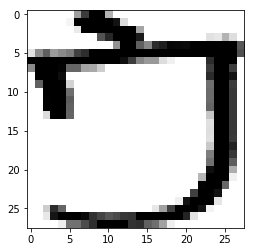

predict_label si
correct_label ko


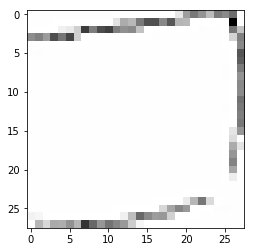

predict_label i
correct_label si


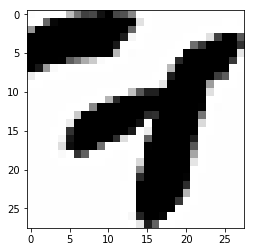

predict_label ke
correct_label sa


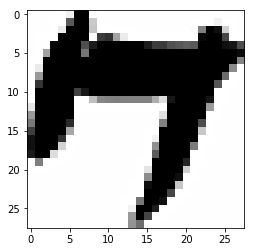

predict_label se
correct_label sa


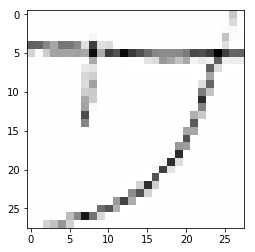

predict_label i
correct_label a


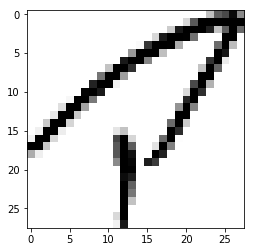

predict_label si
correct_label su


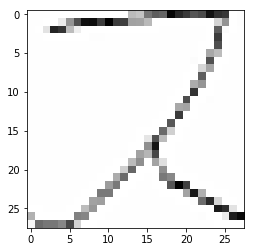

predict_label ku
correct_label ke


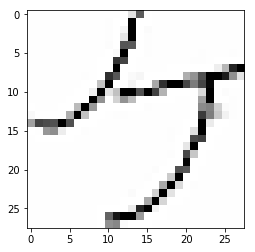

predict_label ki
correct_label sa


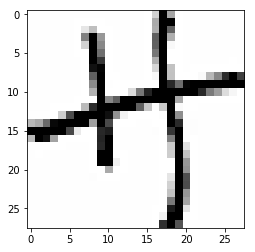

predict_label se
correct_label ka


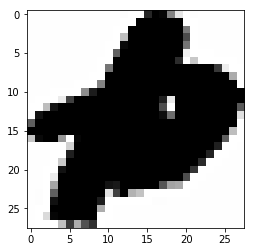

predict_label si
correct_label ku


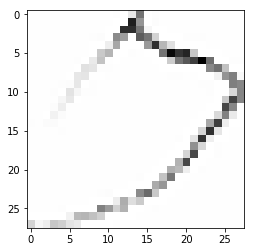

predict_label so
correct_label ke


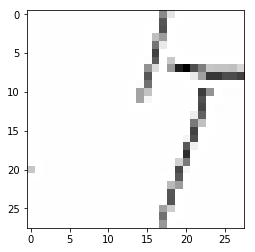

predict_label si
correct_label u


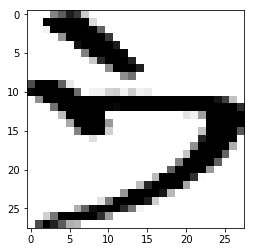

predict_label ke
correct_label sa


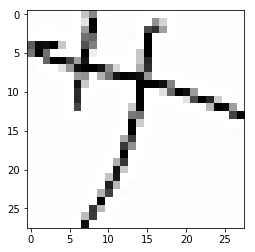

predict_label ku
correct_label ka


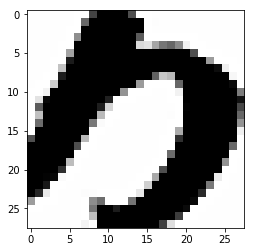

predict_label i
correct_label o


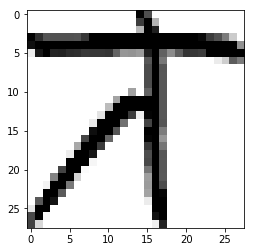

predict_label ki
correct_label e


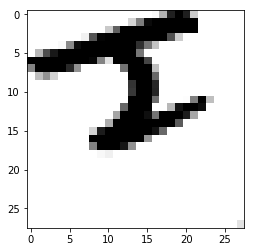

predict_label si
correct_label ko


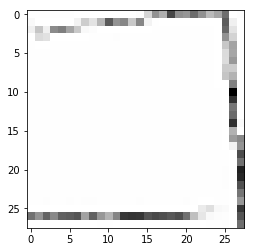

predict_label a
correct_label ki


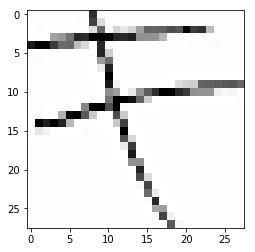

predict_label i
correct_label o


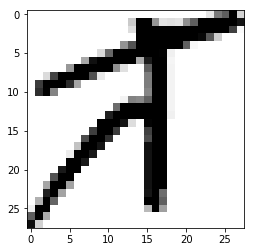

predict_label ku
correct_label ka


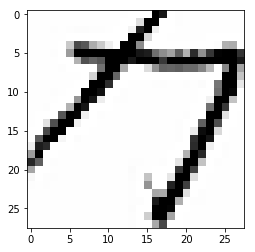

predict_label i
correct_label o


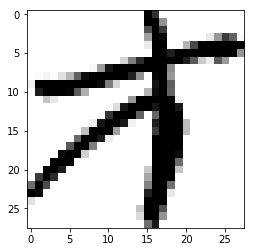

predict_label su
correct_label se


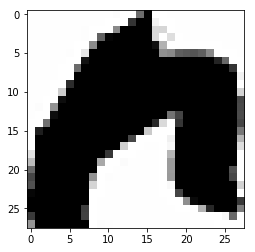

predict_label si
correct_label ke


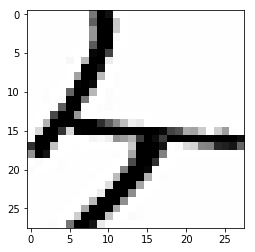

predict_label ke
correct_label ka


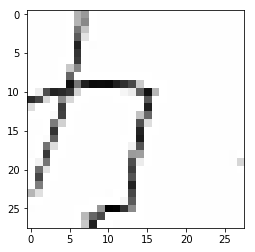

predict_label si
correct_label su


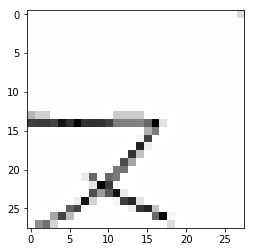

predict_label ke
correct_label se


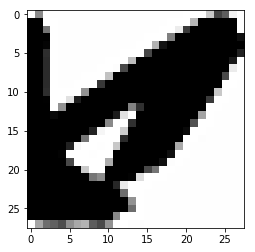

predict_label so
correct_label ku


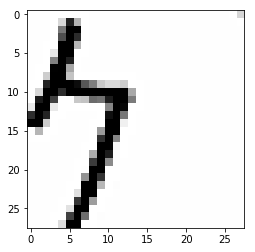

predict_label si
correct_label so


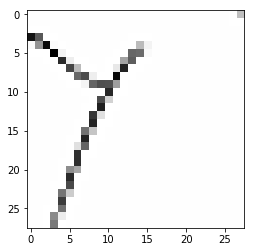

predict_label ku
correct_label ke


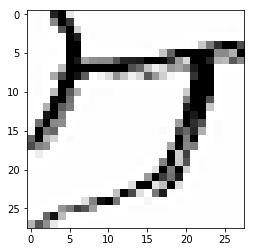

predict_label si
correct_label so


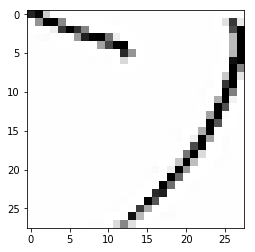

predict_label ka
correct_label ku


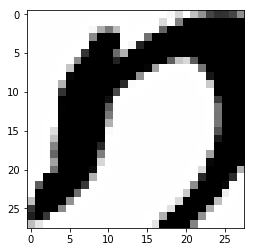

predict_label su
correct_label si


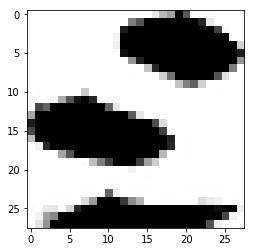

predict_label ki
correct_label su


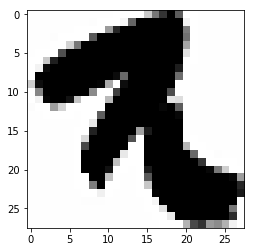

predict_label si
correct_label e


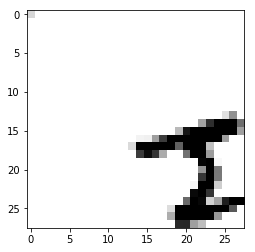

predict_label se
correct_label sa


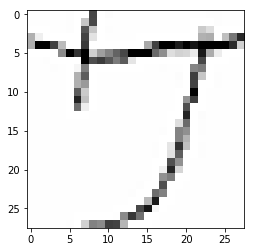

predict_label ku
correct_label ka


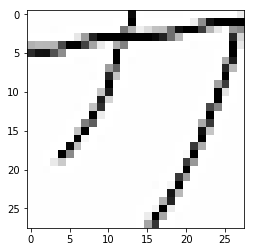

predict_label sa
correct_label ka


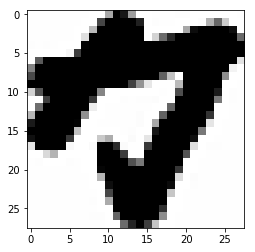

predict_label ku
correct_label ka


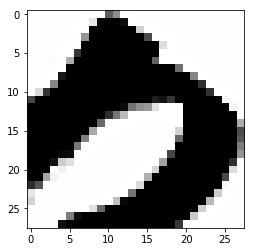

predict_label si
correct_label so


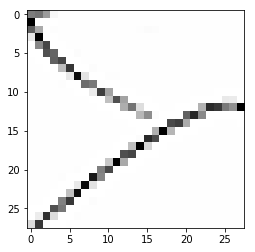

predict_label se
correct_label ka


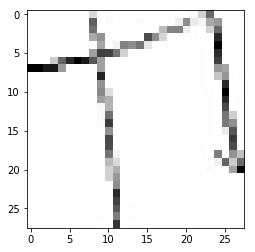

predict_label sa
correct_label u


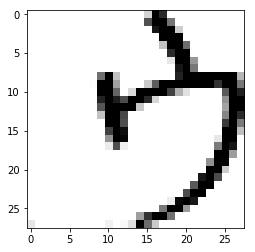

predict_label ke
correct_label si


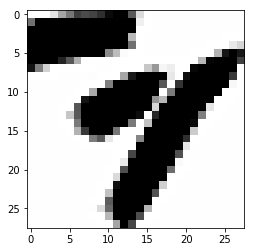

predict_label su
correct_label ki


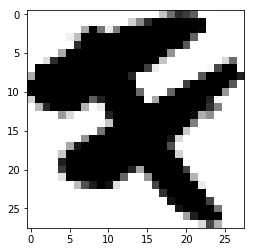

predict_label su
correct_label e


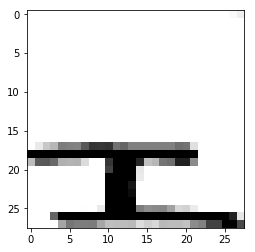

predict_label so
correct_label si


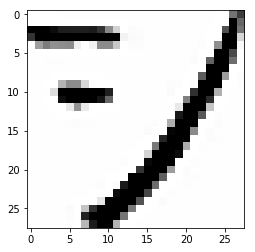

predict_label so
correct_label si


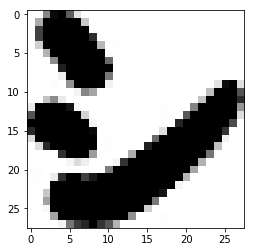

predict_label ka
correct_label se


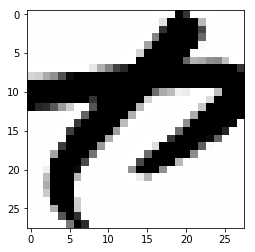

predict_label si
correct_label ko


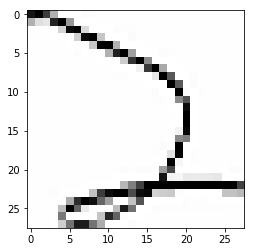

predict_label ku
correct_label a


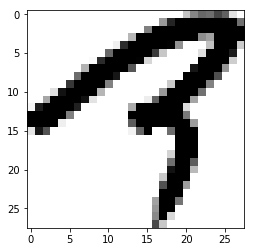

miss_summary

a 2.0
i 1.0
u 4.0
e 3.0
o 3.0
ka 10.0
ki 2.0
ku 5.0
ke 5.0
ko 3.0
sa 5.0
si 5.0
su 3.0
se 4.0
so 3.0


In [9]:
#間違った画像を表示
snet.display_miss_img(X_test, y_test)

## 学習済みモデルの出力

In [10]:
#with open("katakana_model.pickle", "wb") as f:
#    pickle.dump(snet, f)

In [11]:
#CNN層のパラメータを抽出
for idx in range(1, convLayerNum+1):
    with open("model_params\katakana_model_CW" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['CW' + str(idx)], f)
    with open("model_params\katakana_model_Cb" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['Cb' + str(idx)], f)

#全結合層のパラメータを抽出
for idx in range(1, affineLayerNum+1):
    with open("model_params\katakana_model_AW" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['AW' + str(idx)], f)
    with open("model_params\katakana_model_Ab" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['Ab' + str(idx)], f)


#バッチ正規化レイヤのパラメータを抽出
for idx in range(1, bnLayerNum+1):
    with open("model_params\katakana_model_gamma" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['gamma' + str(idx)], f)
    with open("model_params\katakana_model_beta" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.params['beta' + str(idx)], f)
    with open("model_params\katakana_model_moving_mean" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.layers['BatchNorm' + str(idx)].moving_mean, f)
    with open("model_params\katakana_model_moving_var" + str(idx) + ".pickle", "wb") as f:
        pickle.dump(snet.layers['BatchNorm' + str(idx)].moving_var, f)

    

#print("snet.params['beta1']", snet.params['beta1'])
#print("snet.params['gamma1']", snet.params['gamma1'])
#print(snet.layers['BatchNorm1'].moving_mean)
#print(snet.layers['BatchNorm1'].moving_var)